<a href="https://colab.research.google.com/github/SEOYUNJE/Lung-Image-Analysis/blob/main/GradCam/GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## settings
sample_num_setting = 200
epoch_setting = 2
label_smoothing_setting = 0.15
learning_rate_setting = 3e-3
train_batch_setting, valid_batch_setting, test_batch_setting = 16,32,64
fold_num_setting = 1

experiment_setting = {
    'sample_num_setting':sample_num_setting,
	'epoch_setting': epoch_setting,
 'label_smoothing_setting': label_smoothing_setting,
 'learning_rate_setting':learning_rate_setting,
 'train_batch_setting':train_batch_setting,
 'valid_batch_setting':valid_batch_setting,
 'test_batch_setting':test_batch_setting,
 'fold_num_setting':fold_num_setting
}
for i,x in experiment_setting.items():
  print(f"{i}: {x}")

sample_num_setting: 200
epoch_setting: 2
label_smoothing_setting: 0.15
learning_rate_setting: 0.003
train_batch_setting: 16
valid_batch_setting: 32
test_batch_setting: 64
fold_num_setting: 1


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Importing Libraries</b></div>

In [2]:
import gc
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split

import warnings
import albumentations as albu
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None

tensorflow version:  2.17.0
Using 1 GPUs


In [3]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else:
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Load and Read Data</b></div>

In [4]:
!pip install opendatasets -qq

In [5]:
import os
import opendatasets as od

os.environ['KAGGLE_USERNAME'] = 'sehyeoncheon'
os.environ['KAGGLE_KEY'] = 'c16de769c64ea017233c8f7ae30e254f'

!kaggle datasets download -d seoyunje/rapid-cxr-dataset
!unzip -n -q /content/rapid-cxr-dataset.zip -d /content/rapid-cxr-dataset/

!kaggle datasets download -d seanbearden/tf-efficientnet-noisy-student-weights
!unzip -n -q /content/tf-efficientnet-noisy-student-weights.zip -d /content/tf-efficientnet-noisy-student-weights/

!kaggle datasets download -d seoyunje/cxr-unet
!unzip -n -q /content/cxr-unet.zip -d /content/cxr-unet/

Dataset URL: https://www.kaggle.com/datasets/seoyunje/rapid-cxr-dataset
License(s): unknown
100% 3.67G/3.68G [02:08<00:00, 30.2MB/s]
100% 3.68G/3.68G [02:08<00:00, 30.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/seanbearden/tf-efficientnet-noisy-student-weights
License(s): apache-2.0
100% 635M/637M [00:21<00:00, 30.0MB/s]
100% 637M/637M [00:21<00:00, 30.6MB/s]
Dataset URL: https://www.kaggle.com/datasets/seoyunje/cxr-unet
License(s): unknown
 98% 148M/151M [00:06<00:00, 29.7MB/s]
100% 151M/151M [00:06<00:00, 25.5MB/s]


Finding Labels
Edema           500
No Finding      500
Pneumonia       500
Pneumothorax    500
Emphysema       500
Covid           500
Effusion        500
Atelectasis     500
Tuberculosis    393
Name: count, dtype: int64


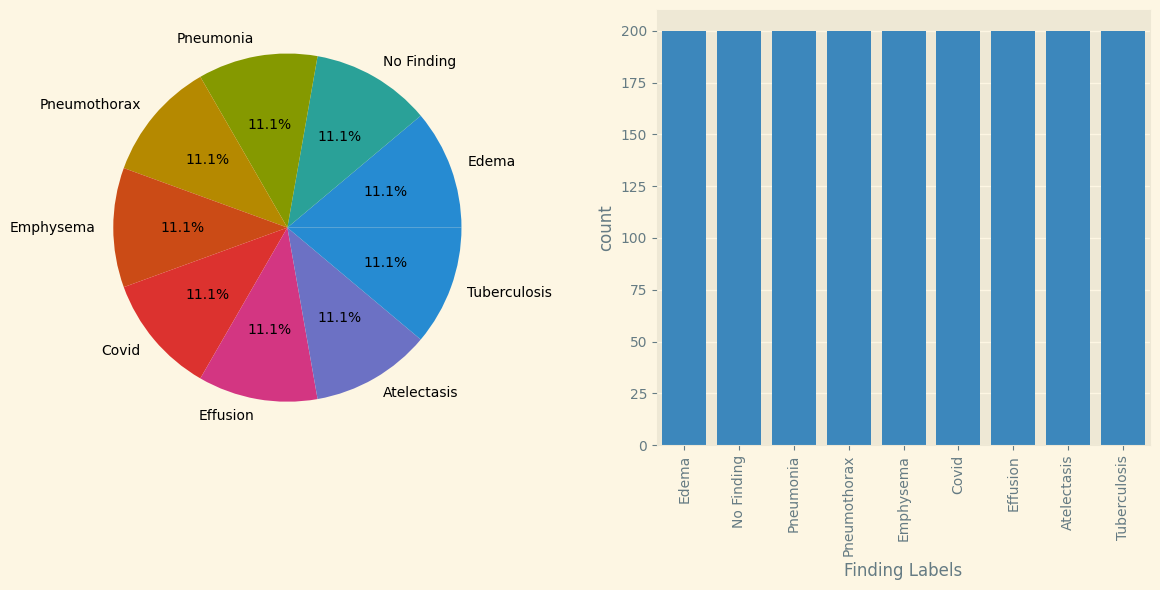

In [6]:
df = pd.read_csv('/content/rapid-cxr-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', '*','*','*', '*'))}

df['path'] = df['Image Index'].map(tmp)

label_counts = df['Finding Labels'].value_counts()
print(label_counts)

df_all = []

for label in ['Edema', 'No Finding', 'Pneumonia', 'Tuberculosis', 'Pneumothorax',  'Emphysema', 'Covid', 'Effusion', 'Atelectasis']:
    n = min(sample_num_setting, (df['Finding Labels'] == label).sum())
    df_all.append(df[df['Finding Labels'] == label].sample(n=n, random_state=42))

df = pd.concat(df_all)
df = df.reset_index(drop=True)

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**PA vs AP**

<Figure size 1200x600 with 0 Axes>

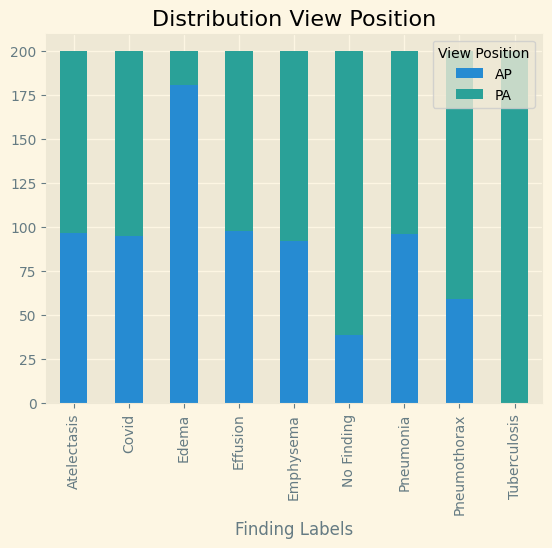

In [7]:
tmp = df.groupby(['Finding Labels','View Position']).size().unstack()
plt.figure(figsize=(12,6))
tmp.plot(kind='bar', stacked=True)
plt.title('Distribution View Position')
plt.show()

**Train & Test Split**

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [9]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
TARGET = df_train.columns[-9:].tolist()
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Pneumothorax',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

In [10]:
df_train.head()

Image Index Finding Labels  \
0               00011814_009.png   Pneumothorax   
1               00012020_011.png   Pneumothorax   
2               00029979_000.png      Emphysema   
3               00003706_001.png   Pneumothorax   
4  person1333_bacteria_3384.jpeg      Pneumonia   

                                                path View Position Patient ID  \
0  /content/rapid-cxr-dataset/lung_diseases/Pneum...            PA      11814   
1  /content/rapid-cxr-dataset/lung_diseases/Pneum...            PA      12020   
2  /content/rapid-cxr-dataset/lung_diseases/Emphy...            PA      29979   
3  /content/rapid-cxr-dataset/lung_diseases/Pneum...            PA       3706   
4  /content/rapid-cxr-dataset/lung_diseases/Pneum...            PA      p_369   

   label_nunique  Edema  No Finding  Pneumonia  Tuberculosis  Pneumothorax  \
0              5    0.0         0.0        0.0           0.0           1.0   
1              4    0.0         0.0        0.0           0.0           1.0   
2              1    0.0         0.0        0.0           0.0           0.0   
3              2    0.0         0.0        0.0           0.0           1.0   
4              1    0.0         0.0        1.0           0.0           0.0   

   Emphysema  Covid  Effusion  Atelectasis  
0        0.0    0.0       0.0          0.0  
1        0.0    0.0       0.0          0.0  
2        1.0    0.0       0.0          0.0  
3        0.0    0.0       0.0          0.0  
4        0.0    0.0       0.0          0.0

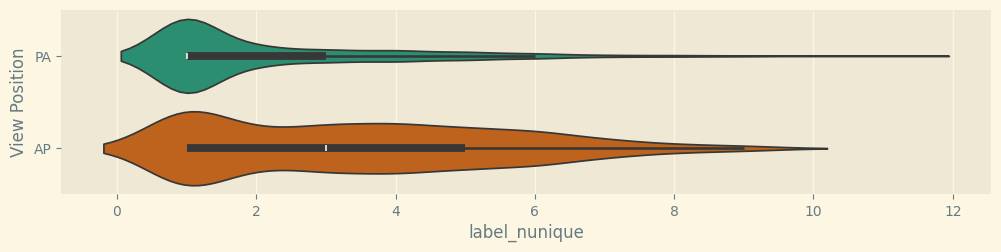

In [11]:
# @title View Position vs label_nunique

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_train['View Position'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_train, x='label_nunique', y='View Position', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Evaluation

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classification(all_true, all_oof, TARGET):
    # 실제 클래스와 예측 클래스 생성
    y_true = np.argmax(all_true, axis=1)
    y_pred = np.argmax(all_oof, axis=1)

    # 분류 보고서 생성
    report = classification_report(y_true, y_pred, target_names=TARGET, output_dict=True)
    df = pd.DataFrame(report).transpose()
    accuracy = report['accuracy']
    macro_f1 = report['macro avg']['f1-score']

    # Precision 및 Recall 그래프
    index = np.arange(len(TARGET))

    plt.figure(figsize=(12, 3))
    plt.bar(index - 0.2, df['precision'][:-3], width=0.4, label='Precision', color='skyblue')
    plt.bar(index + 0.2, df['recall'][:-3], width=0.4, label='Recall', color='lightgreen')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall by Class')

    plt.xticks(index, TARGET)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # DataFrame 반환
    return df, accuracy, macro_f1

def plot_pr_curve_and_calculate_metrics(all_true, all_oof, target_names):
    n_classes = all_true.shape[1]
    class_ap_list = []
    ap_scores = []

    plt.figure()

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(all_true[:, i], all_oof[:, i])
        ap = average_precision_score(all_true[:, i], all_oof[:, i])
        ap_scores.append(ap)

        plt.plot(recall, precision, lw=2, label=f'{target_names[i]} (AP={ap:.2f})')
        class_ap_list.append({'Class': target_names[i], 'AP': ap})

    class_ap_df = pd.DataFrame(class_ap_list)
    mAP = np.mean(ap_scores)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.text(0.5, 0.02, f'mAP: {mAP:.4f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()

    print(f"\nMean Average Precision (mAP): {mAP:.4f}")
    print('Average Precision per Class:')
    print(class_ap_df)

    return class_ap_df, mAP

def plot_roc_and_calculate_auc(all_true, all_oof, TARGET):
    plt.figure(figsize=(5,5))

    for i, target in enumerate(TARGET):
        fpr, tpr, _ = roc_curve(all_true[:, i], all_oof[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{target} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # AUC 계산
    auc_scores = [roc_auc_score(all_true[:, i], all_oof[:, i]) for i in range(len(TARGET))]
    train_auc_df = pd.DataFrame({'Class': TARGET, 'AUC': auc_scores})

    return train_auc_df

def calculate_cross_entropy_loss(all_true, all_oof):
    y_true = np.argmax(all_true, axis=1)
    ce_loss = log_loss(y_true, all_oof)
    return ce_loss

def calculate_ece(all_true, all_oof, n_bins=10):
    y_true = np.argmax(all_true, axis=1)
    y_pred = np.argmax(all_oof, axis=1)
    confidences = np.max(all_oof, axis=1)
    accuracies = (y_pred == y_true)

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += (avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece

def visualize_loss_distribution(all_true, all_oof, TARGET):
    # 원핫 인코딩된 변수로 변환
    y_true = np.argmax(all_true, axis=1)
    y_pred = np.argmax(all_oof, axis=1)

    # 카테고리별 손실 계산
    loss = tf.keras.losses.categorical_crossentropy(all_true, all_oof)

    # 1. 레이블별 손실 분포 시각화
    plt.figure(figsize=(15, 3))
    plt.title('Distribution of Loss for Each Label')
    sns.boxplot(x=[TARGET[true_label] for true_label in y_true],
                y=loss.numpy(),
                order=TARGET)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 2. 레이블별 손실 통계 계산
    label_stats = pd.DataFrame({
        'Label': [TARGET[true_label] for true_label in y_true],
        'Loss': loss.numpy()
    }).groupby('Label')['Loss'].agg(['mean', 'std']).reindex(TARGET)
    label_stats.columns = ['Mean Loss', 'Std Dev']

    # 3. 레이블별 평균 손실 시각화
    plt.figure(figsize=(15, 3))
    plt.title('Mean Loss for Each Label')
    sns.barplot(x=label_stats.index, y='Mean Loss', data=label_stats, order=TARGET)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("Label-wise Loss Statistics:")
    print(label_stats)


    # 4. 상위 5개 및 하위 5개 레이블 출력
    print("\nTop 5 labels with highest mean loss:")
    print(label_stats.sort_values('Mean Loss', ascending=False).head())

    print("\nBottom 5 labels with lowest mean loss:")
    print(label_stats.sort_values('Mean Loss', ascending=False).tail())

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [13]:
import albumentations as albu
print(albu.__version__)

1.4.14


In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, augment3 = False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.augment3 = augment3
        self.preprocess = preprocess
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        if self.augment3: X = self.__augment3(X)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.zeros((len(indexes), 256, 256, 3), dtype='float32')
        y = np.zeros((len(indexes), len(TARGET)), dtype='float32')

        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256, 256), Image.Resampling.LANCZOS)
            img = np.array(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            X[j, :, :] = img
            y[j,] = row[TARGET]

        return X, y

    def __augment1(self, img_batch):

        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),

        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch


    def __augment2(self, img_batch, mixup_prob=0.1):
        batch_size, height, width, channels = img_batch.shape

        idx = np.random.permutation(batch_size)
        lam = np.random.beta(2.0, 2.0)

        for i in range(batch_size):
            if np.random.rand() <= mixup_prob:
                j = idx[i]

                img_batch[i] = img_batch[i] * lam + img_batch[j] * (1-lam)

        return img_batch

    def __augment3(self, img_batch):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            albu.RandomRotate90(p=0.5),
          #  albu.RandomBrightnessContrast(p=0.5),
          #  albu.HueSaturationValue(p=1, hue_shift_limit=1),
            albu.GaussianBlur(blur_limit=(3, 7), p=0.3),
          #  albu.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            albu.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.3),
            albu.Rotate(limit=45, p=0.5),
            albu.Resize(256, 256, always_apply=True)  # 항상 256x256으로 다시 조정
        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build ResNet Model</b></div>

In [15]:
!pip install -q git+https://github.com/qubvel/classification_models.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


**Install ResNet**

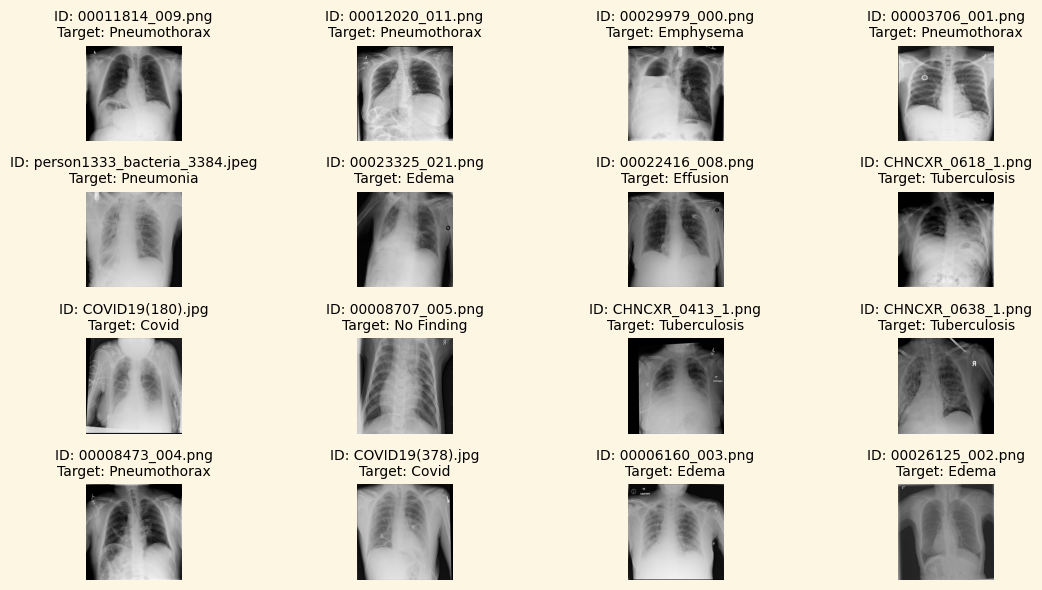

In [16]:
from classification_models.tfkeras import Classifiers

resnet18, preprocess_input = Classifiers.get('resnet18')

ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, batch_size=16, shuffle=True, augment1=True, augment2=False, augment3=False, preprocess=preprocess_input)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

#### Macro F1_Score

In [17]:
def f1_score(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)

    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):
        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())

        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1_score)

    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

**ReduceLROnPleateau in Callbacks**

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

EPOCHS = epoch_setting

lr = ReduceLROnPlateau(monitor = 'val_f1_score', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [158]:
import tensorflow as tf

def build_model():
    inp = tf.keras.layers.Input(shape=(256,256,3))
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3))
    res_model._name = 'resnet18'

    ## Freezing Layer(10% Layer)
    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False

    x = res_model(inp)
    last_conv_layer = x  # Store the output of the last convolutional layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)

    # Create two models
    model = tf.keras.Model(inputs=inp, outputs=output, name='hybrid')
    grad_model = tf.keras.Model(inputs=inp, outputs=[last_conv_layer, output])

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing_setting)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setting)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy', f1_score])

    return model, grad_model


In [42]:
from tensorflow.keras.utils import plot_model

model, grad_model = build_model()
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

Model: "hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 8, 8, 512)           │      11,186,889 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,191,506 (42.69 MB)

 Trainable params: 11,174,025 (42.63 MB)

 Non-trainable params: 17,481 (68.29 KB)

In [43]:
grad_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 8, 8, 512)           │      11,186,889 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,191,506 (42.69 MB)

 Trainable params: 11,174,025 (42.63 MB)

 Non-trainable params: 17,481 (68.29 KB)

#### StratifiedKFold

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. TRAIN</b></div>

In [46]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(fold_num_setting): # Fold는 1개만

    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=False, augment3=False, batch_size=train_batch_setting, preprocess=preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=valid_batch_setting, preprocess=preprocess_input)

    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)

    K.clear_session()
    with strategy.scope():
        model, grad_model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1_score'])
        all_history['Train F1'].append(history.history['f1_score'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')

    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['path'].values)

    del model, oof, train_gen, valid_gen
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 1152, valid size 288
#########################
Epoch 1/2
72/72 ━━━━━━━━━━━━━━━━━━━━ 65s 717ms/step - accuracy: 0.2205 - f1_score: 0.1353 - loss: 2.6453 - val_accuracy: 0.1146 - val_f1_score: 0.0228 - val_loss: nan - learning_rate: 0.0030
Epoch 2/2
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 664ms/step - accuracy: 0.3829 - f1_score: 0.2729 - loss: 1.9047 - val_accuracy: 0.1319 - val_f1_score: 0.0498 - val_loss: 31.3459 - learning_rate: 0.0030
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6. TRAIN-RESULT</b></div>

In [47]:
all_oof

array([[6.61978334e-18, 8.79247427e-01, 1.17935516e-01, ...,
        4.76980304e-12, 1.06898084e-11, 2.81643332e-03],
       [2.69080918e-08, 9.89187777e-01, 1.96136716e-06, ...,
        5.54814108e-07, 2.76842820e-06, 1.60239462e-04],
       [1.63265668e-11, 9.99708951e-01, 6.77517509e-09, ...,
        7.39980299e-09, 9.61920410e-09, 4.29882721e-06],
       ...,
       [6.81282927e-07, 9.92193460e-01, 4.18521677e-06, ...,
        1.05119261e-05, 5.93135082e-05, 3.63620056e-04],
       [1.13140004e-08, 9.84677792e-01, 1.42509528e-02, ...,
        4.67105323e-08, 1.29794114e-06, 1.01603311e-03],
       [2.90371793e-09, 9.97560024e-01, 8.80686566e-04, ...,
        7.24500978e-07, 1.68155950e-07, 1.40692119e-03]], dtype=float32)

#### 1. 지표

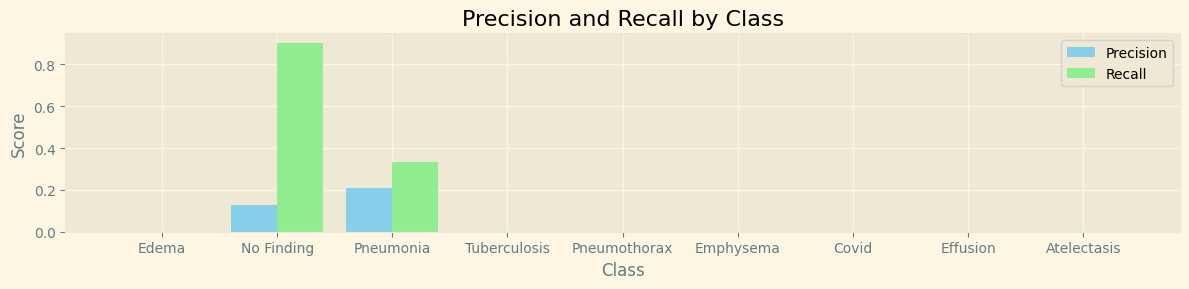

Train Accuracy: 0.132
Train f1 score: 0.053


precision    recall  f1-score     support
Edema          0.000000  0.000000  0.000000   34.000000
No Finding     0.126126  0.903226  0.221344   31.000000
Pneumonia      0.208333  0.333333  0.256410   30.000000
Tuberculosis   0.000000  0.000000  0.000000   32.000000
Pneumothorax   0.000000  0.000000  0.000000   33.000000
Emphysema      0.000000  0.000000  0.000000   34.000000
Covid          0.000000  0.000000  0.000000   31.000000
Effusion       0.000000  0.000000  0.000000   32.000000
Atelectasis    0.000000  0.000000  0.000000   31.000000
accuracy       0.131944  0.131944  0.131944    0.131944
macro avg      0.037162  0.137395  0.053084  288.000000
weighted avg   0.035277  0.131944  0.050535  288.000000

In [48]:
# 지표 1
train_df,train_accuracy, train_f1 = evaluate_classification(all_true, all_oof, TARGET)
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Train f1 score: {train_f1:.3f}')
train_df

#### 2. 지표2- PR curve

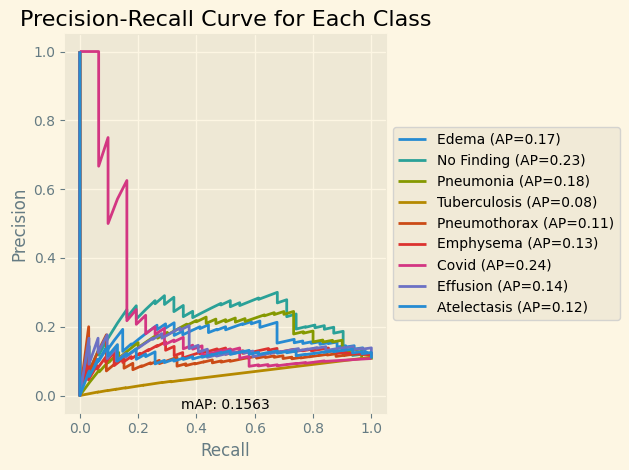


Mean Average Precision (mAP): 0.1563
Average Precision per Class:
          Class        AP
0         Edema  0.173312
1    No Finding  0.229053
2     Pneumonia  0.176792
3  Tuberculosis  0.081801
4  Pneumothorax  0.113315
5     Emphysema  0.126959
6         Covid  0.237850
7      Effusion  0.144669
8   Atelectasis  0.122735


In [49]:
## 지표 2) PR curve | AP | mAP
train_ap, mAP = plot_pr_curve_and_calculate_metrics(all_true, all_oof, TARGET)

#### 3. 지표3 Confusion Matrix

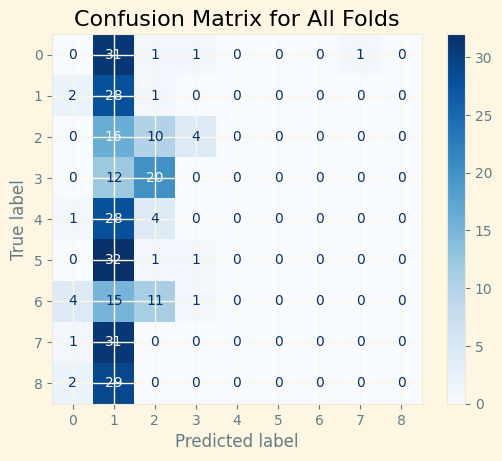

array([[ 0, 31,  1,  1,  0,  0,  0,  1,  0],
       [ 2, 28,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 16, 10,  4,  0,  0,  0,  0,  0],
       [ 0, 12, 20,  0,  0,  0,  0,  0,  0],
       [ 1, 28,  4,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  1,  1,  0,  0,  0,  0,  0],
       [ 4, 15, 11,  1,  0,  0,  0,  0,  0],
       [ 1, 31,  0,  0,  0,  0,  0,  0,  0],
       [ 2, 29,  0,  0,  0,  0,  0,  0,  0]])

In [50]:
# 지표 3) 모든 폴드의 데이터를 합친 전체 confusion matrix도 생성합니다.
train_cm = confusion_matrix(np.argmax(all_true, axis=1),
                          np.argmax(all_oof, axis=1),
                          labels=[x for x in range(len(TARGET))])

disp_all = ConfusionMatrixDisplay(confusion_matrix=train_cm,
                                  display_labels=[x for x in range(len(TARGET))])
disp_all.plot(cmap='Blues')
plt.title('Confusion Matrix for All Folds')
plt.show()
train_cm

#### 4. 지표4 - Train & Valid | Loss & F1 & Accuracy

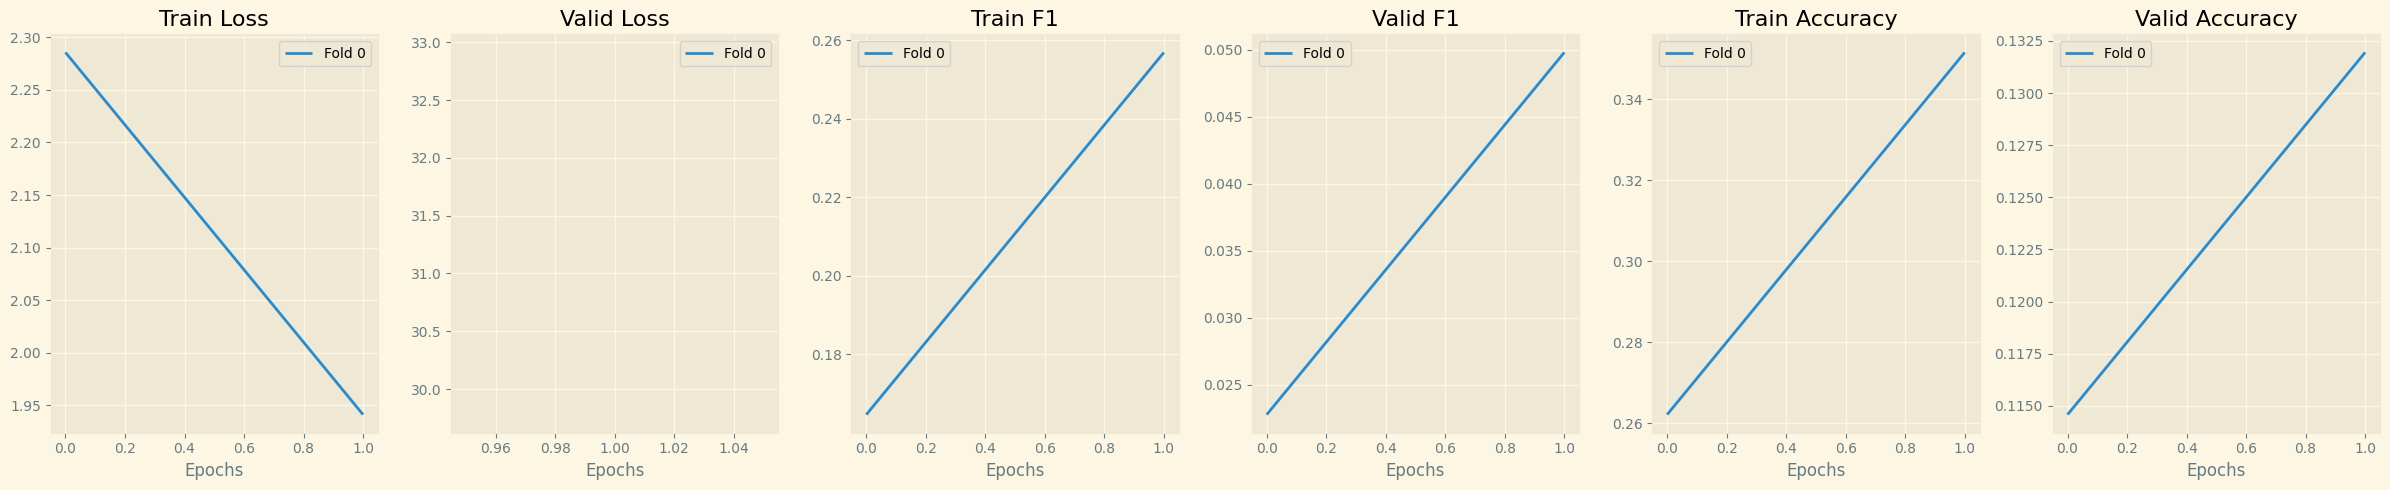

Train Loss     Valid Loss        Valid F1        Train F1  \
Fold                                                                  
0     [2.286, 1.941]  [nan, 31.346]  [0.023, 0.050]  [0.165, 0.257]   

      Valid Accuracy  Train Accuracy  
Fold                                  
0     [0.115, 0.132]  [0.262, 0.352]

In [51]:
## 지표 4) Train & Valid | Loss & F1 & Accuracy
if LOAD_MODELS_FROM is None:
	plt.figure(figsize=(24,5))

	metrics = ['Train Loss', 'Valid Loss', 'Train F1', 'Valid F1', 'Train Accuracy', 'Valid Accuracy']

	for idx, metric in enumerate(metrics, 1):
		plt.subplot(1, 6, idx)
		plt.title(metric)
		for fold, i in enumerate(all_history[metric]):
			plt.plot(i, label=f'Fold {fold}')
		plt.xlabel('Epochs')
		plt.legend()

	plt.tight_layout()
	plt.show()
history_train_df = pd.DataFrame(all_history)
history_train_df.index.name = 'Fold'
history_train_df = history_train_df.applymap(lambda x: [f'{i:.3f}' for i in x] if isinstance(x, list) else x)
history_train_df

AUC (Area Under the Curve):


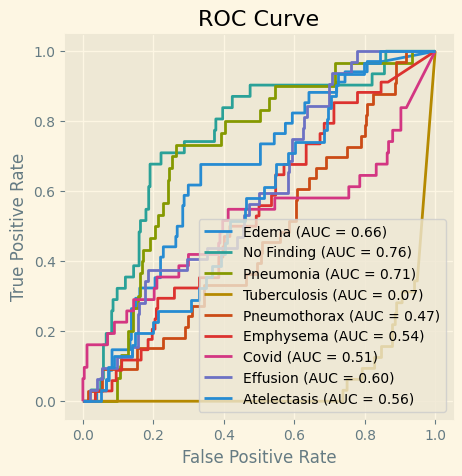

          Class       AUC
0         Edema  0.658175
1    No Finding  0.755115
2     Pneumonia  0.713824
3  Tuberculosis  0.068542
4  Pneumothorax  0.468687
5     Emphysema  0.536938
6         Covid  0.511171
7      Effusion  0.595093
8   Atelectasis  0.563449


In [52]:
# 지표 5 AUC, ROC curve
print('AUC (Area Under the Curve):')
train_auc_df = plot_roc_and_calculate_auc(all_true, all_oof, TARGET)
print(train_auc_df)

In [53]:
### 지표 6) CEE | ECE

train_CEE = calculate_cross_entropy_loss(all_true, all_oof)
train_ECE = calculate_ece(all_true, all_oof)

print('#### TRAIN CEE and ECE')
print(f"Cross-entropy loss: {train_CEE:.4f}\nExpected Calibration Error: {train_ECE:.4f}")

#### TRAIN CEE and ECE
Cross-entropy loss: 10.2857
Expected Calibration Error: 0.7653


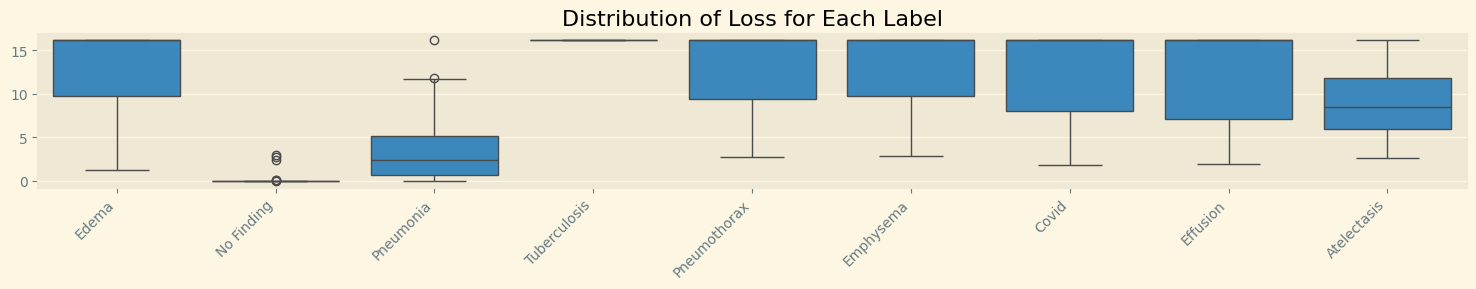

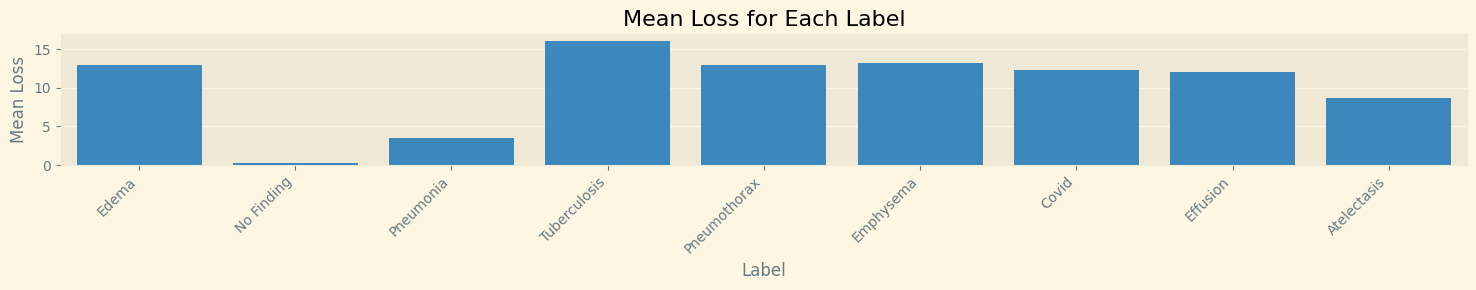

Label-wise Loss Statistics:
              Mean Loss   Std Dev
Label                            
Edema         12.935929  4.648688
No Finding     0.260775  0.807937
Pneumonia      3.552155  4.082696
Tuberculosis  16.118095  0.000000
Pneumothorax  12.903883  4.573206
Emphysema     13.256561  4.411050
Covid         12.318483  5.207938
Effusion      12.052675  5.195419
Atelectasis    8.728569  3.876219

Top 5 labels with highest mean loss:
              Mean Loss   Std Dev
Label                            
Tuberculosis  16.118095  0.000000
Emphysema     13.256561  4.411050
Edema         12.935929  4.648688
Pneumothorax  12.903883  4.573206
Covid         12.318483  5.207938

Bottom 5 labels with lowest mean loss:
             Mean Loss   Std Dev
Label                           
Covid        12.318483  5.207938
Effusion     12.052675  5.195419
Atelectasis   8.728569  3.876219
Pneumonia     3.552155  4.082696
No Finding    0.260775  0.807937


In [54]:
# 7 손실 분포
visualize_loss_distribution(all_true, all_oof, TARGET)


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. TEST</b></div>

In [ ]:
def get_gradcam(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        # If pred_index is not specified, take the predicted class
        if pred_index is None:
            pred_index = tf.argmax(preds[0])

        pred_index = tf.cast(pred_index, dtype=tf.int32)
        class_channel = preds[:, pred_index]

    # Compute the gradient of the top predicted class with respect to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Global average pooling over the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by the pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]

    # Make sure to multiply the pooled grads with the last conv layer output for each channel
    heatmap = tf.einsum('ijk,k->ij', last_conv_layer_output, pooled_grads)  # Use einsum to ensure proper broadcasting

    # Normalize the heatmap between 0 and 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Resize heatmap to match the size of the input image
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (img_array.shape[1], img_array.shape[2]))  # Resize to (256, 256)
    heatmap = tf.squeeze(heatmap)  # Remove the singleton dimensions

    return heatmap.numpy()

# 이미지 시각화 함수
import matplotlib.pyplot as plt

def display_gradcam(img_array, heatmap, alpha=0.4, is_color=True):
    batch_size = img_array.shape[0]  # Get the batch size

    for i in range(batch_size):
        # Load the i-th original image
        img = np.squeeze(img_array[i])  # Squeeze any extra dimensions

        # Resize heatmap to match the size of the original image
        heatmap_resized = np.uint8(255 * heatmap)
        heatmap_resized = tf.expand_dims(heatmap_resized, axis=-1)
        heatmap_resized = tf.image.resize(heatmap_resized, (img.shape[0], img.shape[1]))
        heatmap_resized = tf.squeeze(heatmap_resized).numpy()

        # Apply the color map and overlay with the image
        heatmap_resized = plt.cm.jet(heatmap_resized)[:, :, :3]  # RGB heatmap
        img = img / 255.0  # Normalize the original image
        superimposed_img = heatmap_resized * alpha + img

        superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values to range [0, 1]

        # Display the superimposed image
        plt.imshow(superimposed_img)
        plt.axis('off')
        plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 기존 preds = [] 코드 바로 밑에 Grad-CAM을 추가
preds = []
heatmaps = []  # Grad-CAM heatmaps 저장할 리스트
model, grad_model = build_model()

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=test_batch_setting, preprocess=preprocess_input)

for i in range(fold_num_setting):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')
    else:
        model.load_weights(f'ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')

    # Update grad_model weights to match the loaded model
    grad_model.set_weights(model.get_weights())

    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)

    # Grad-CAM을 계산하기 위한 부분
    img_array, _ = next(iter(test_gen))  # test_gen에서 배치 데이터 가져오기
    for img in img_array[:64]:  # 첫 번째 배치에서 64개의 이미지에 대해 Grad-CAM 생성
        heatmap = get_gradcam(grad_model, np.expand_dims(img, axis=0))  # pred_res 대신 grad_model의 예측값 사용
        heatmaps.append(heatmap)

pred_res = np.mean(preds, axis=0)

Fold 1
2/6 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step 

In [141]:
pred_res[0]

array([9.6759294e-08, 9.8822486e-01, 1.7897638e-03, 1.2774031e-03,
       8.1579917e-04, 9.9862712e-07, 4.8884176e-06, 3.9248403e-05,
       7.8470809e-03], dtype=float32)

In [151]:
# Create img_array from the generator
img_array = []

# Using the existing generator (gen) to create the img_array
for i, (x, y) in enumerate(gen):
    img_array.extend(x)
    if len(img_array) >= 5:  # Collect only 5 images for Grad-CAM demonstration
        img_array = img_array[:5]  # Limit to 5 images
        break

# Convert img_array to numpy array
img_array = np.array(img_array)
img_array.shape

(5, 256, 256, 3)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>8. TEST-RESULT</b></div>

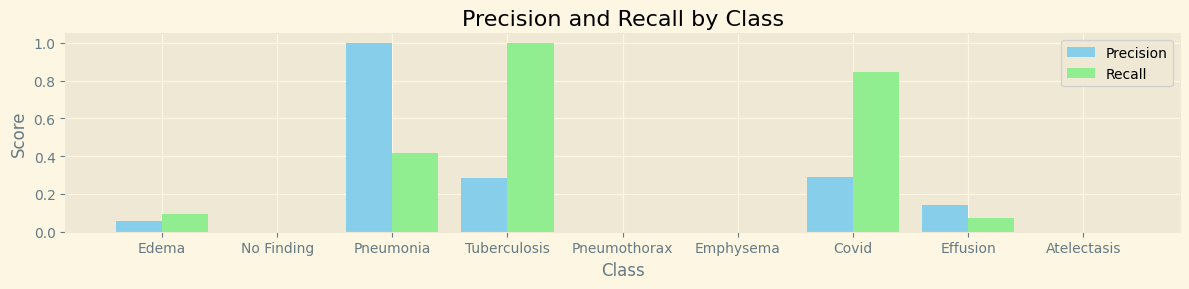

Test Accuracy: 0.283
Test f1 score: 0.181


precision    recall  f1-score     support
Edema          0.054545  0.093750  0.068966   32.000000
No Finding     0.000000  0.000000  0.000000   47.000000
Pneumonia      1.000000  0.416667  0.588235   48.000000
Tuberculosis   0.286822  1.000000  0.445783   37.000000
Pneumothorax   0.000000  0.000000  0.000000   36.000000
Emphysema      0.000000  0.000000  0.000000   32.000000
Covid          0.288889  0.847826  0.430939   46.000000
Effusion       0.142857  0.073171  0.096774   41.000000
Atelectasis    0.000000  0.000000  0.000000   41.000000
accuracy       0.283333  0.283333  0.283333    0.283333
macro avg      0.197013  0.270157  0.181189  360.000000
weighted avg   0.220844  0.283333  0.196464  360.000000

In [32]:
# 지표 1
test_df,test_accuracy, test_f1 = evaluate_classification(df_test[TARGET].values, pred_res, TARGET)
print(f'Test Accuracy: {test_accuracy:.3f}')
print(f'Test f1 score: {test_f1:.3f}')
test_df

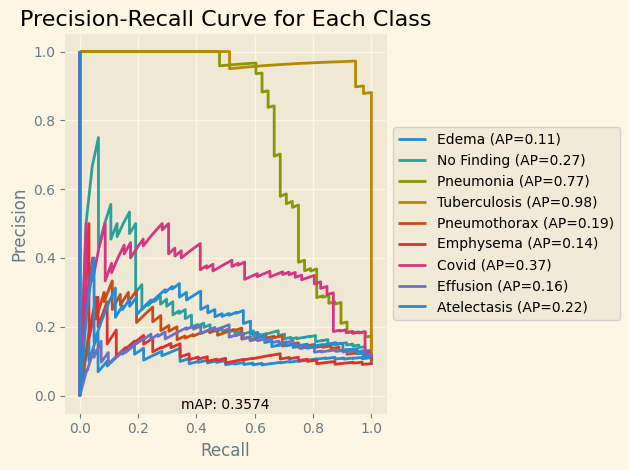


Mean Average Precision (mAP): 0.3574
Average Precision per Class:
          Class        AP
0         Edema  0.113610
1    No Finding  0.266017
2     Pneumonia  0.771859
3  Tuberculosis  0.978490
4  Pneumothorax  0.194108
5     Emphysema  0.142502
6         Covid  0.370207
7      Effusion  0.157051
8   Atelectasis  0.223147


In [33]:
## 지표 2) PR curve | AP | mAP
test_ap, test_mAP = plot_pr_curve_and_calculate_metrics(df_test[TARGET].values, pred_res, TARGET)

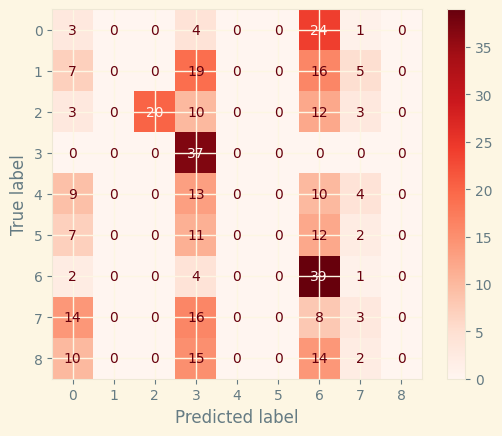

In [34]:
# 지표3 Confusion Matrix
cm = confusion_matrix(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), labels=[x for x in range(len(TARGET))])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(len(TARGET))])
display.plot(cmap='Reds')

plt.show()

지표4 패스

TEST AUC (Area Under the Curve):


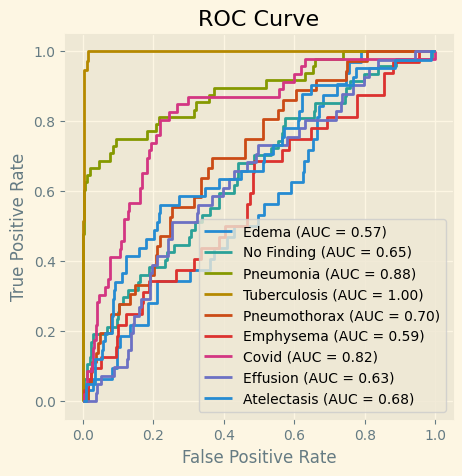

          Class       AUC
0         Edema  0.574028
1    No Finding  0.649378
2     Pneumonia  0.884749
3  Tuberculosis  0.997908
4  Pneumothorax  0.698131
5     Emphysema  0.588034
6         Covid  0.816879
7      Effusion  0.628871
8   Atelectasis  0.682162


In [35]:
# 지표 5 AUC, ROC curve
print('TEST AUC (Area Under the Curve):')
test_auc_df = plot_roc_and_calculate_auc(df_test[TARGET].values, pred_res, TARGET)
print(test_auc_df)

In [36]:
# 6. Cross-Entropy Error | Expected Calibration Error
y_true_test_2 = df_test[TARGET].values

test_CEE = calculate_cross_entropy_loss(y_true_test_2, pred_res)
test_ECE = calculate_ece(y_true_test_2, pred_res)

print('#### TEST CEE and ECE')
print(f"Cross-Entropy Error(CEE): {test_CEE:.4f}")
print(f"Expected Calibration Error(ECE): {test_ECE:.4f}")

#### TEST CEE and ECE
Cross-Entropy Error(CEE): 3.5958
Expected Calibration Error(ECE): 0.4057


Loss distribution for TEST


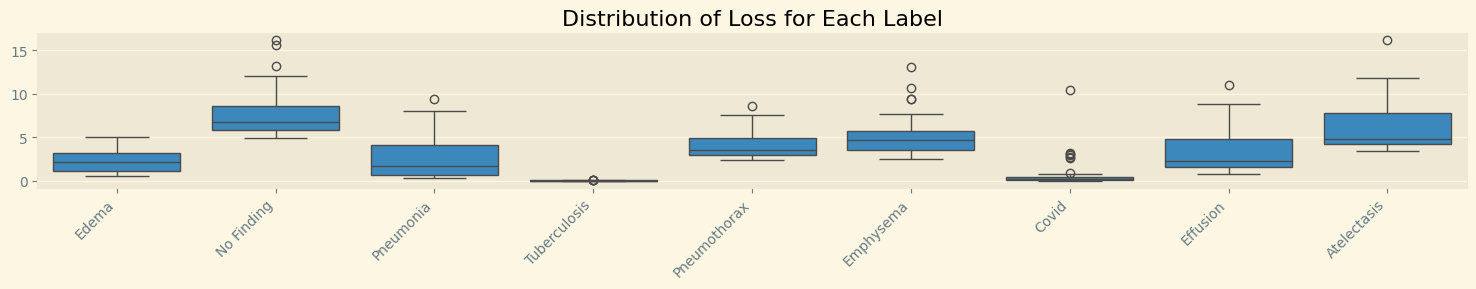

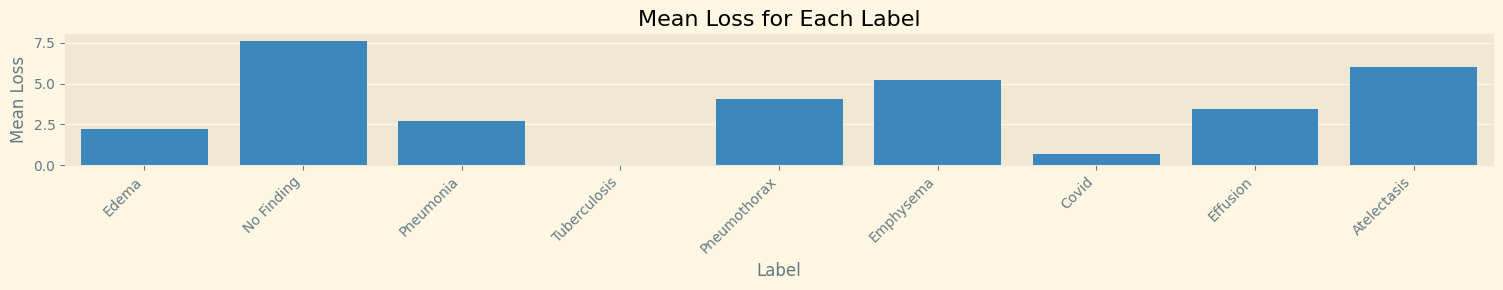

Label-wise Loss Statistics:
              Mean Loss   Std Dev
Label                            
Edema          2.242902  1.225330
No Finding     7.648913  2.643850
Pneumonia      2.684069  2.496186
Tuberculosis   0.012477  0.019831
Pneumothorax   4.058024  1.542224
Emphysema      5.203872  2.476763
Covid          0.703791  1.707590
Effusion       3.447413  2.547031
Atelectasis    6.047118  2.653257

Top 5 labels with highest mean loss:
              Mean Loss   Std Dev
Label                            
No Finding     7.648913  2.643850
Atelectasis    6.047118  2.653257
Emphysema      5.203872  2.476763
Pneumothorax   4.058024  1.542224
Effusion       3.447413  2.547031

Bottom 5 labels with lowest mean loss:
              Mean Loss   Std Dev
Label                            
Effusion       3.447413  2.547031
Pneumonia      2.684069  2.496186
Edema          2.242902  1.225330
Covid          0.703791  1.707590
Tuberculosis   0.012477  0.019831


In [37]:
# 7. 손실 분포
print('Loss distribution for TEST')
visualize_loss_distribution(df_test[TARGET].values, pred_res, TARGET)


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>9. Overall Result</b></div>

In [38]:
print(f'LEARNING RATE: {learning_rate_setting}')
print()

print(f'train_accuracy: {train_accuracy:.4f}')
print(f'train_f1: {train_f1:.4f}')
print(f'test_accuracy: {test_accuracy:.4f}')
print(f'test f1: {test_f1:.4f}')

print()
print(f'mAP: {mAP:.4f}')

print()
print(f'train CEE: {train_CEE:.4f}')
print(f'train ECE: {train_ECE:.4f}')
print(f'test CEE: {test_CEE:.4f}')
print(f'test_ECE: {test_ECE:.4f}')


print(f'\n{test_accuracy:.4f} | {test_f1:.4f} | {test_CEE:.4f} | {test_ECE:.4f} | {train_accuracy:.4f} | {train_f1:.4f} | {train_CEE:.4f} | {train_ECE:.4f}')


LEARNING RATE: 0.003

train_accuracy: 0.2882
train_f1: 0.2051
test_accuracy: 0.2833
test f1: 0.1812

mAP: 0.3528

train CEE: 3.5324
train ECE: 0.3955
test CEE: 3.5958
test_ECE: 0.4057

0.2833 | 0.1812 | 3.5958 | 0.4057 | 0.2882 | 0.2051 | 3.5324 | 0.3955


In [39]:
from datetime import datetime

for i,x in experiment_setting.items():
    print(f'{i}: {x}')

print()

current_time = datetime.now()
print(f'완료 시간: {current_time.strftime("%Y-%m-%d %H:%M:%S")}')


sample_num_setting: 200
epoch_setting: 2
label_smoothing_setting: 0.15
learning_rate_setting: 0.003
train_batch_setting: 16
valid_batch_setting: 32
test_batch_setting: 64
fold_num_setting: 1

완료 시간: 2024-09-12 04:46:58


In [40]:
print(TARGET)
print(f'{learning_rate_setting} | {test_accuracy:.4f} | {test_f1:.4f} | {test_CEE:.4f} | {test_ECE:.4f} | {train_accuracy:.4f} | {train_f1:.4f} | {train_CEE:.4f} | {train_ECE:.4f}')


['Edema', 'No Finding', 'Pneumonia', 'Tuberculosis', 'Pneumothorax', 'Emphysema', 'Covid', 'Effusion', 'Atelectasis']
0.003 | 0.2833 | 0.1812 | 3.5958 | 0.4057 | 0.2882 | 0.2051 | 3.5324 | 0.3955


Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Generating Grad-CAM for target: Edema


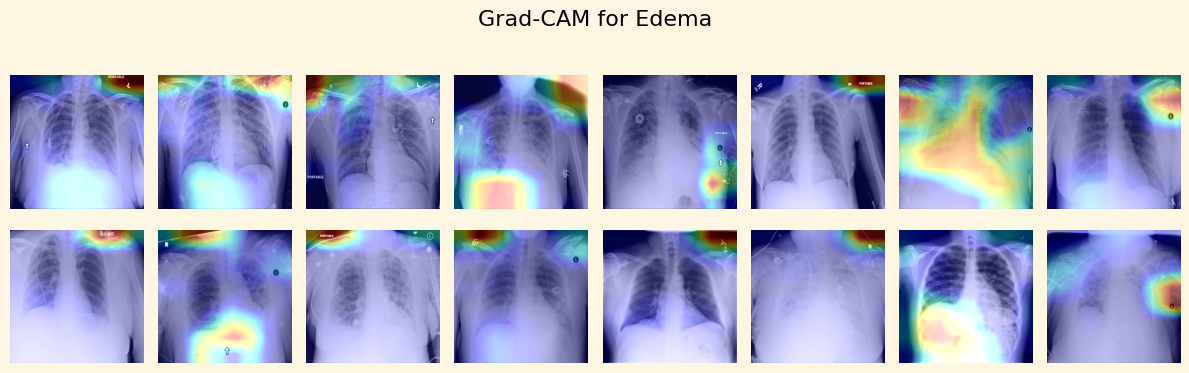

Generating Grad-CAM for target: No Finding


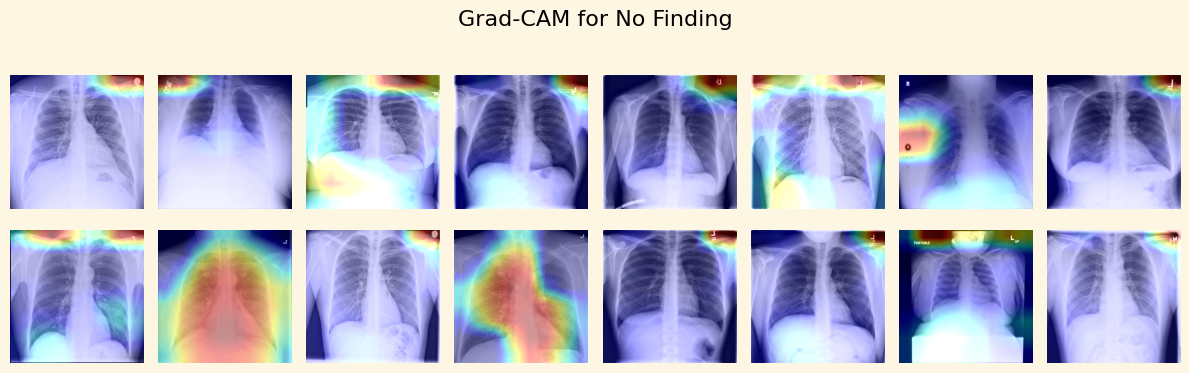

Generating Grad-CAM for target: Pneumonia


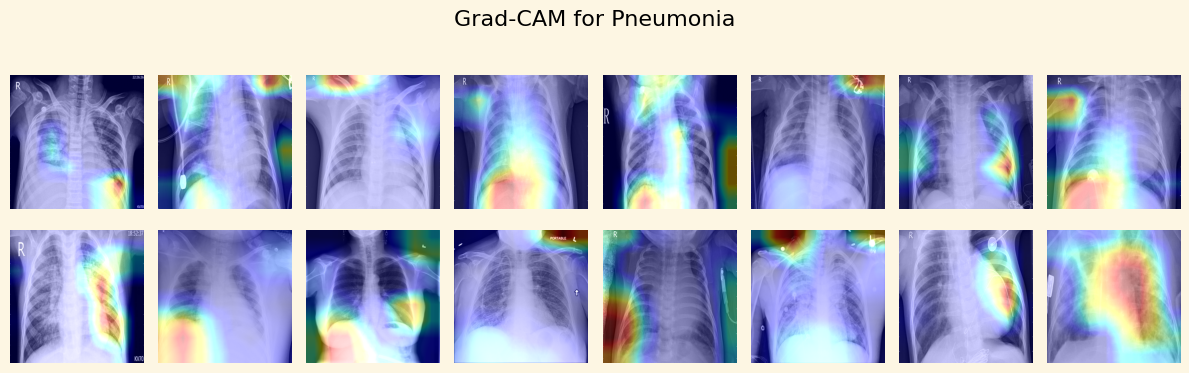

Generating Grad-CAM for target: Tuberculosis


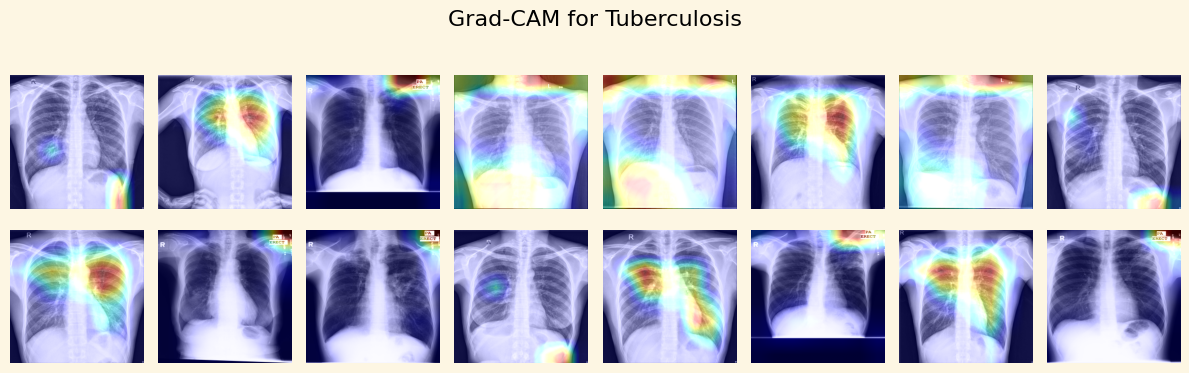

Generating Grad-CAM for target: Pneumothorax


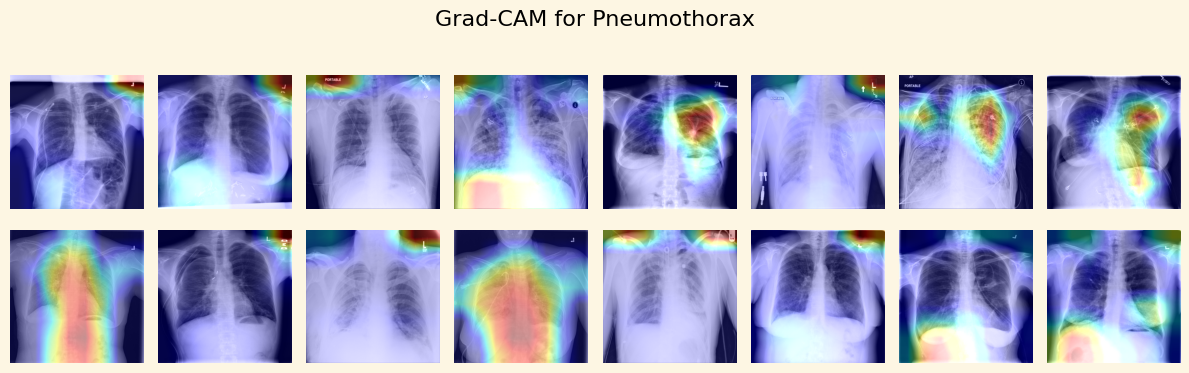

Generating Grad-CAM for target: Emphysema


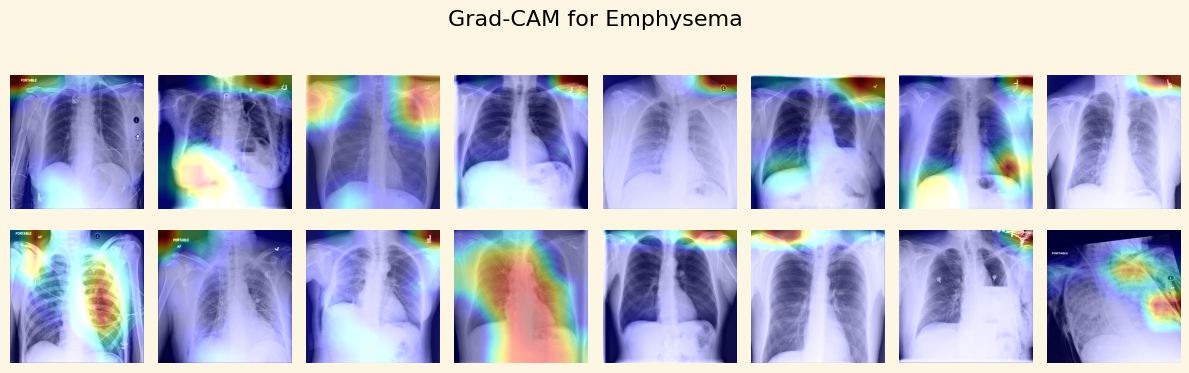

Generating Grad-CAM for target: Covid


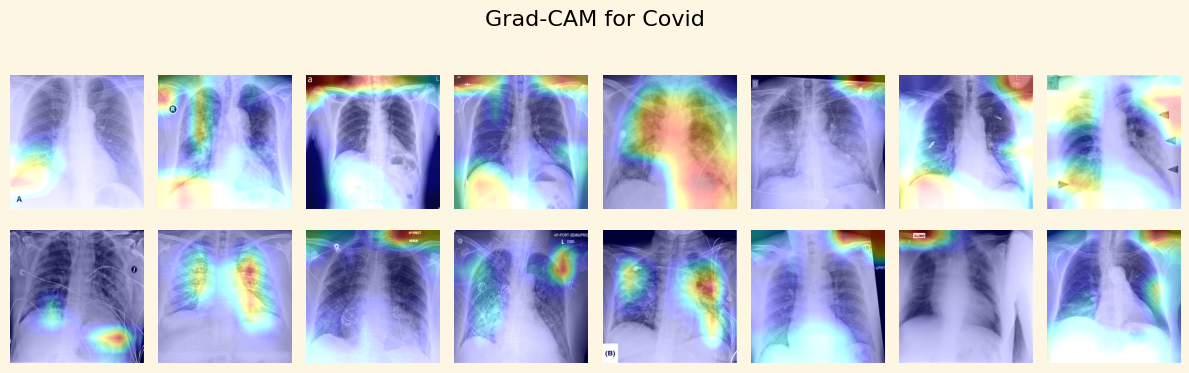

Generating Grad-CAM for target: Effusion


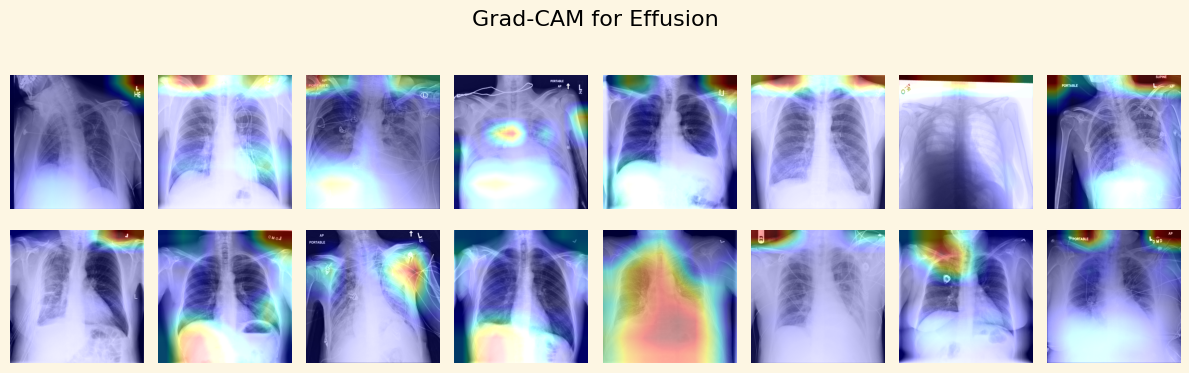

Generating Grad-CAM for target: Atelectasis


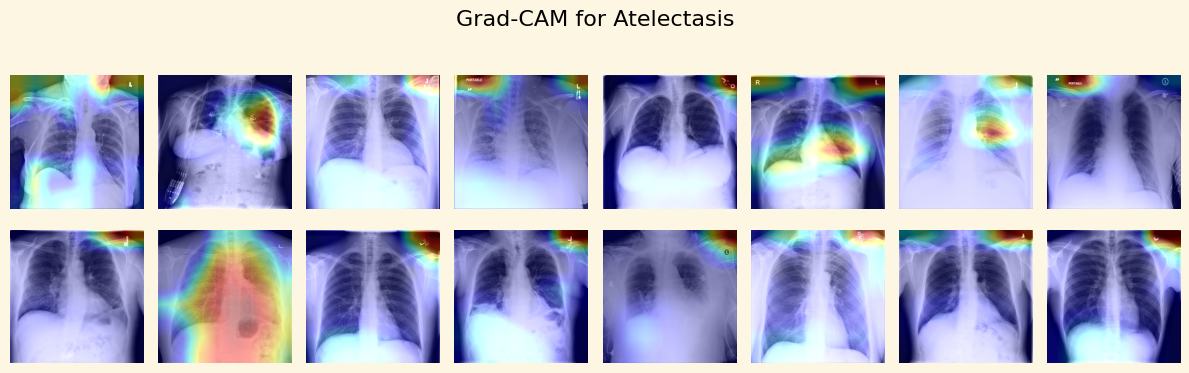

In [185]:
import matplotlib.pyplot as plt
import numpy as np

# 기존 preds = [] 코드 바로 밑에 Grad-CAM을 추가
preds = []
heatmaps = []  # Grad-CAM heatmaps 저장할 리스트
model, grad_model = build_model()

TARGETS = ['Edema', 'No Finding', 'Pneumonia', 'Tuberculosis', 'Pneumothorax', 'Emphysema', 'Covid', 'Effusion', 'Atelectasis']

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=test_batch_setting, preprocess=preprocess_input)

for i in range(fold_num_setting):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')
    else:
        model.load_weights(f'ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')

    # Update grad_model weights to match the loaded model
    grad_model.set_weights(model.get_weights())

    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)

pred_res = np.mean(preds, axis=0)

# 각 타겟별로 Grad-CAM 생성 및 시각화를 위한 새로운 데이터 제너레이터 생성
for target_index, target in enumerate(TARGETS):
    print(f"Generating Grad-CAM for target: {target}")

    # 각 타겟별로 필터링된 데이터프레임 생성
    df_target = df_test[df_test['Finding Labels'].str.contains(target)]

    # 타겟에 맞는 데이터 제너레이터 생성
    target_gen = DataGenerator(df_target, shuffle=False, batch_size=test_batch_setting, preprocess=preprocess_input)

    # 배치에서 16개 이미지를 선택
    img_array, _ = next(iter(target_gen))  # target_gen에서 배치 데이터 가져오기
    img_array = img_array[:16]  # 16개의 이미지만 사용

    # Grad-CAM heatmaps 생성
    heatmaps = []
    for img in img_array:
        heatmap = get_gradcam(grad_model, np.expand_dims(img, axis=0))  # pred_res 대신 grad_model의 예측값 사용
        heatmaps.append(heatmap)

    # 16개 이미지를 4x4 격자로 시각화
    fig, axs = plt.subplots(2,8, figsize=(12, 4))
    axs = axs.flatten()

    for i, (img, heatmap) in enumerate(zip(img_array, heatmaps)):
        # Heatmap에 컬러맵 적용
        heatmap = np.uint8(255 * heatmap)  # 0~255 사이로 정규화
        heatmap = plt.cm.jet(heatmap)[:, :, :3]  # 컬러맵 적용 후 RGB로 변환
        heatmap = np.clip(heatmap, 0, 1)  # 값을 0~1로 클리핑

        # 원본 이미지와 heatmap 합성
        img = img / 255.0  # 원본 이미지 정규화
        superimposed_img = heatmap * 0.4 + img  # heatmap을 원본 이미지에 겹침
        superimposed_img = np.clip(superimposed_img, 0, 1)  # 값을 0에서 1 사이로 클리핑

        axs[i].imshow(superimposed_img)  # Grad-CAM 시각화
        axs[i].axis('off')  # 축 숨기기

    plt.suptitle(f"Grad-CAM for {target}", size=16)
    plt.tight_layout()
    plt.show()
